In [11]:
# Import required libraries :
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test
from scipy import stats
from copy import deepcopy

In [12]:
#Read the dataset :
sofa_vpn = pd.read_csv("pn_virus/patients_sofa.csv",index_col=0)
sofa_bpn = pd.read_csv("pn_bact/patients_sofa.csv",index_col=0)

# 统计死亡率

In [156]:
# Sepsis 统计死亡率
sofa_vpn = sofa_vpn.loc[sofa_vpn["hr"]==0]
sofa_bpn = sofa_bpn.loc[sofa_bpn["hr"]==0]
a = []
b = []
c = []

# 无spesis
var_pn = sofa_vpn.loc[sofa_vpn["sofa_24hours"]<2,:] 
a.append("%s/%s(%.1f)" %(np.sum(var_pn["30day_death"]),var_pn.shape[0],100*np.mean(var_pn["30day_death"])))

var_bpn = sofa_bpn.loc[sofa_bpn["sofa_24hours"]<2,:]
b.append("%s/%s(%.1f)" %(np.sum(var_bpn["30day_death"]),var_bpn.shape[0],100*np.mean(var_bpn["30day_death"])))

c.append(stats.chi2_contingency(
    [[np.sum(var_pn["30day_death"]),
    var_pn.shape[0]-np.sum(var_pn["30day_death"])],
    [np.sum(var_bpn["30day_death"]),
    var_bpn.shape[0]-np.sum(var_bpn["30day_death"])]],correction=False)[1])

# 有sepsis
var_pn = sofa_vpn.loc[sofa_vpn["sofa_24hours"]>=2,:] 
a.append("%s/%s(%.1f)" %(np.sum(var_pn["30day_death"]),var_pn.shape[0],100*np.mean(var_pn["30day_death"])))

var_bpn = sofa_bpn.loc[sofa_bpn["sofa_24hours"]>=2,:]
b.append("%s/%s(%.1f)" %(np.sum(var_bpn["30day_death"]),var_bpn.shape[0],100*np.mean(var_bpn["30day_death"])))

c.append(stats.chi2_contingency(
    [[np.sum(var_pn["30day_death"]),
    var_pn.shape[0]-np.sum(var_pn["30day_death"])],
    [np.sum(var_bpn["30day_death"]),
    var_bpn.shape[0]-np.sum(var_bpn["30day_death"])]],correction=False)[1])
pd.DataFrame([a,b,c]).T

,0,1,2
0,2/145(1.4),38/492(7.7),0.005647
1,52/318(16.4),277/1547(17.9),0.508034


In [170]:
# 统计分段死亡率
sofa_vpn = sofa_vpn.loc[sofa_vpn["hr"]==0]
sofa_bpn = sofa_bpn.loc[sofa_bpn["hr"]==0]
dic = {}
adc = []
bdc = []
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12]:
    # 有sepsis
    sofa_re = sofa_vpn.loc[sofa_vpn["sofa_24hours"]==i,:]    
    sofa_total = sofa_bpn.loc[sofa_bpn["sofa_24hours"]==i,:]

    a = np.sum(sofa_re["30day_death"])
    b = sofa_re.shape[0] - np.sum(sofa_re["30day_death"])
    c = np.sum(sofa_total["30day_death"])
    d = sofa_total.shape[0] - np.sum(sofa_total["30day_death"])

    tab = [[a,b],[c,d]]
    if (a+b+c+d > 40)  & (min([a,b,c,d]) > 5):
      p = "%.2f" % (stats.chi2_contingency(tab,correction=False)[1])
    if (a+b+c+d > 40)  & (min([a,b,c,d]) < 5) & (min([a,b,c,d]) > 1): 
      p = "%.2f" % (stats.chi2_contingency(tab,correction=True)[1])
    if (a+b+c+d < 40)  or (min([a,b,c,d]) < 1):
      p = "%.2f" % (stats.fisher_exact(tab)[1])
    dic[i] = ["%s/%s(%.2f)" % (a, a+b, a/(a+b)*100),
          "%s/%s(%.2f)" % (c, c+d, c/(c+d)*100),
          p]
    adc.append(a/(a+b)*100)
    bdc.append(c/(c+d)*100)
pd.DataFrame(dic).T


,0,1,2
0,0/74(0.00),13/234(5.56),0.04
1,2/71(2.82),25/258(9.69),0.10
2,6/71(8.45),33/304(10.86),0.55
3,5/71(7.04),24/288(8.33),0.55
4,4/58(6.90),36/260(13.85),0.22
5,9/35(25.71),41/192(21.35),0.57
6,7/29(24.14),41/158(25.95),0.84
7,4/22(18.18),27/123(21.95),0.91
8,6/10(60.00),19/79(24.05),0.04
9,1/7(14.29),16/50(32.00),0.04


/tmp/ipykernel_1185147/2812044987.py:6: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cdf = pd.concat([adf,bdf],0)


<AxesSubplot:xlabel='SOFA', ylabel='Mortality'>

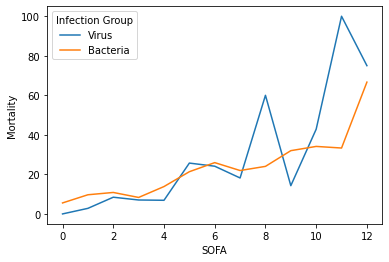

In [171]:
import seaborn as sns
adf = pd.DataFrame(adc)
adf["Infection Group"] = "Virus"
bdf = pd.DataFrame(bdc)
bdf["Infection Group"] = "Bacteria"
cdf = pd.concat([adf,bdf],0)
cdf["SOFA"] = cdf.index
cdf.index = list(range(cdf.shape[0]))
cdf.columns = ["Mortality", "Infection Group", "SOFA"]
sns.lineplot(x="SOFA", y="Mortality", hue="Infection Group",data=cdf)

# Sruvial Curve

In [159]:
sofa_bpn["pn"] = 0
sofa_vpn["pn"] = 1

In [164]:
sofa_apn = pd.concat([sofa_vpn,sofa_bpn],0)
sofa_apn = sofa_apn.loc[sofa_apn["hr"]==0,:]
sofa_pn = sofa_apn.loc[sofa_apn["sofa_24hours"]<2,:]

/tmp/ipykernel_1185147/2368901005.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  sofa_apn = pd.concat([sofa_vpn,sofa_bpn],0)


      removed  observed  censored  entrance  at_risk  KM_estimate
0.0         4         4         0       637      637     0.993721
1.0         1         1         0         0      633     0.992151
2.0         5         5         0         0      632     0.984301
3.0         5         5         0         0      627     0.976452
4.0         3         3         0         0      622     0.971743
5.0         1         1         0         0      619     0.970173
6.0         1         1         0         0      618     0.968603
7.0         2         2         0         0      617     0.965463
8.0         5         5         0         0      615     0.957614
9.0         1         1         0         0      610     0.956044
12.0        4         4         0         0      609     0.949765
13.0        2         2         0         0      605     0.946625
14.0        1         1         0         0      603     0.945055
15.0        2         2         0         0      602     0.941915
17.0      

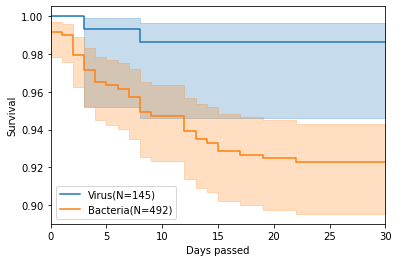

6.107159848472826e-03


In [165]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
fit = kmf.fit(sofa_pn["death_day"], sofa_pn["30day_death"])
fit.median_survival_time_
print(pd.concat([fit.event_table, fit.survival_function_], axis = 1))

g1 = sofa_pn["pn"] == 1  
g2 = sofa_pn["pn"] == 0 
kmf_A = KaplanMeierFitter() 

kmf_A.fit(sofa_pn["death_day"].loc[g1], sofa_pn["30day_death"].loc[g1], label = "Virus(N=%s)" % sofa_pn["death_day"].loc[g1].shape[0])
kmf_B = KaplanMeierFitter() 
kmf_B.fit(sofa_pn["death_day"].loc[g2], sofa_pn["30day_death"].loc[g2], label = "Bacteria(N=%s)" % sofa_pn["death_day"].loc[g2].shape[0])

fig, axes = plt.subplots()
kmf_A.plot(ax = axes, show_censors = True)
kmf_B.plot(ax = axes, show_censors = True)
plt.xlabel("Days passed")
plt.ylabel("Survival")
# plt.title("Sruvival Curve")
plt.xlim([0,30])
# plt.ylim([0.6,1])
plt.show()

from lifelines.statistics import logrank_test
lr = logrank_test(sofa_pn["death_day"].loc[g1], 
                  sofa_pn["death_day"].loc[g2],
                  sofa_pn["30day_death"].loc[g1], 
                  sofa_pn["30day_death"].loc[g2])
print(lr.p_value)

# COX regression

In [18]:
sofa_apn = sofa_vpn
sofa_apn = sofa_apn.loc[sofa_apn["hr"]==0,:]
sofa_pn = sofa_apn

In [20]:
for i in ['respiration_24hours', 'coagulation_24hours', 'liver_24hours','cardiovascular_24hours', 'cns_24hours', 'renal_24hours','sofa_24hours']:
    sofa_pn[i] = pd.cut(sofa_pn[i], [0, 1, 20], labels = ['<2', '>=2'])

/tmp/ipykernel_2830543/3681366401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sofa_pn[i] = pd.cut(sofa_pn[i], [-1, 0, 20], labels = ['<1', '>=1'])
/tmp/ipykernel_2830543/3681366401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sofa_pn[i] = pd.cut(sofa_pn[i], [-1, 0, 20], labels = ['<1', '>=1'])
/tmp/ipykernel_2830543/3681366401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [21]:
sofa_pn = sofa_pn[['death_day','30day_death', 'respiration_24hours', 'coagulation_24hours', 'liver_24hours','cardiovascular_24hours', 'cns_24hours', 'renal_24hours','sofa_24hours']]
sofa_pn.columns = ['death_day','30day_death', 'respiration', 'coagulation', 'liver','cardiovascular', 'cns', 'renal','sofa']
df_dummy = pd.get_dummies(sofa_pn, drop_first = True)
df_dummy.head()

,death_day,30day_death,respiration_>=1,coagulation_>=1,liver_>=1,cardiovascular_>=1,cns_>=1,renal_>=1,sofa_>=1
0,8,1,1,1,0,0,0,0,1
211,31,0,1,0,0,0,0,0,1
328,31,0,1,0,0,1,0,1,1
856,31,0,0,0,0,1,0,1,1
887,31,0,0,0,0,1,0,1,1


In [22]:
from lifelines import CoxPHFitter
cox1 = CoxPHFitter(penalizer=0.0001)  
cox1.fit(df_dummy, duration_col = "death_day", event_col = "30day_death")  
cox1.print_summary()    
cox1.AIC_partial_

<lifelines.CoxPHFitter: fitted with 463 total observations, 409 right-censored observations>
             duration col = 'death_day'
                event col = '30day_death'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 463
number of events observed = 54
   partial log-likelihood = -292.69
         time fit was run = 2022-11-19 11:04:51 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
respiration_>=1      1.20       3.32       0.29             0.63             1.77                 1.87                 5.89
coagulation_>=1      0.30       1.36       0.28            -0.25             0.86                 0.78                 2.35
liver_>=1            1.40       4.05       0.30             0.81             1.99                 2.24                 7.34
cardiovascular_>=1   0.40       1.49       0.27            -0.14             0.93                 0.87                 2.54
cns_>=1              0.80       2.22       0.32             0.18             1.42                 1.19                 4.14
renal_>=1            0.85       2.35       0.28             0.30             1.41                 1.34                 4.10
sofa_>=1             4.18      65.42       5.57            -6.74            15.11                 0.00             3.63e+06

                     cmp to    z      p   -log2(p)
covariate                                         
respiration_>=1        0.00 4.10 <0.005      14.55
coagulation_>=1        0.00 1.08   0.28       1.84
liver_>=1              0.00 4.62 <0.005      18.00
cardiovascular_>=1     0.00 1.45   0.15       2.76
cns_>=1                0.00 2.51   0.01       6.38
renal_>=1              0.00 3.00 <0.005       8.52
sofa_>=1               0.00 0.75   0.45       1.14
---
Concordance = 0.79
Partial AIC = 599.38
log-likelihood ratio test = 71.06 on 7 df
-log2(p) of ll-ratio test = 40.01

5.993812709257195e+02

<AxesSubplot:xlabel='log(HR) (95% CI)'>

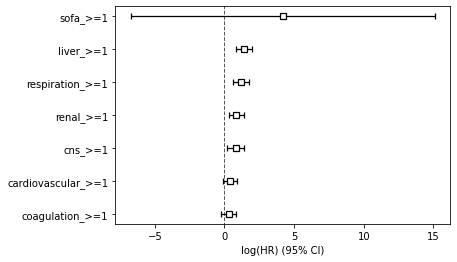

In [23]:
cox1.plot()